In [1]:
%pip install pandas numpy scikit-learn xgboost matplotlib seaborn

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from xgboost import plot_importance

In [15]:
data = pd.read_csv("../Synthetic_Financial_datasets_log.csv")
data = data.sample(n=200000, random_state=42)

data.shape
data.head

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 3737323 to 1027972
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            200000 non-null  int64  
 1   type            200000 non-null  object 
 2   amount          200000 non-null  float64
 3   nameOrig        200000 non-null  object 
 4   oldbalanceOrg   200000 non-null  float64
 5   newbalanceOrig  200000 non-null  float64
 6   nameDest        200000 non-null  object 
 7   oldbalanceDest  200000 non-null  float64
 8   newbalanceDest  200000 non-null  float64
 9   isFraud         200000 non-null  int64  
 10  isFlaggedFraud  200000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 18.3+ MB


In [16]:

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 3737323 to 1027972
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            200000 non-null  int64  
 1   type            200000 non-null  object 
 2   amount          200000 non-null  float64
 3   nameOrig        200000 non-null  object 
 4   oldbalanceOrg   200000 non-null  float64
 5   newbalanceOrig  200000 non-null  float64
 6   nameDest        200000 non-null  object 
 7   oldbalanceDest  200000 non-null  float64
 8   newbalanceDest  200000 non-null  float64
 9   isFraud         200000 non-null  int64  
 10  isFlaggedFraud  200000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 18.3+ MB


In [17]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [18]:
# Encode the 'type' column
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])

# Encode the 'nameOrig' and 'nameDest' columns
data['nameOrig'] = label_encoder.fit_transform(data['nameOrig'])
data['nameDest'] = label_encoder.fit_transform(data['nameDest'])

print(data['type'])
print("---------------------------------")
print(data['nameOrig'])
print("---------------------------------")
print(data['nameDest'])


3737323    0
264914     3
85647      0
5899326    4
2544263    0
          ..
670946     4
3032934    1
4751985    4
1239897    0
1027972    3
Name: type, Length: 200000, dtype: int64
---------------------------------
3737323    161776
264914      27262
85647       77408
5899326    130999
2544263    180696
            ...  
670946      60966
3032934    179627
4751985       881
1239897       234
1027972    180860
Name: nameOrig, Length: 200000, dtype: int64
---------------------------------
3737323     98067
264914     146943
85647       33620
5899326     31240
2544263      5128
            ...  
670946      13078
3032934     60386
4751985     42046
1239897     64933
1027972    114111
Name: nameDest, Length: 200000, dtype: int64


In [19]:
# Select features and target
X = data.drop('isFraud', axis=1)  # Select features
y = data['isFraud']  # Select target

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (120000, 10)
Testing data shape: (80000, 10)


In [21]:
# Create the XGBoost classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    n_estimators=100
    
)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [17]:
# Save the model
model.save_model('xgboost_fraud_model_with_names.h5')
print("Model saved successfully as 'xgboost_fraud_model_with_names.h5'")

Model saved successfully as 'xgboost_fraud_model_with_names.h5'


c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:01:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [22]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("ROC-AUC Score:", roc_auc)

Accuracy: 0.9996125
Confusion Matrix:
 [[79893     3]
 [   28    76]]
ROC-AUC Score: 0.9984215056496523


<Figure size 1000x800 with 0 Axes>

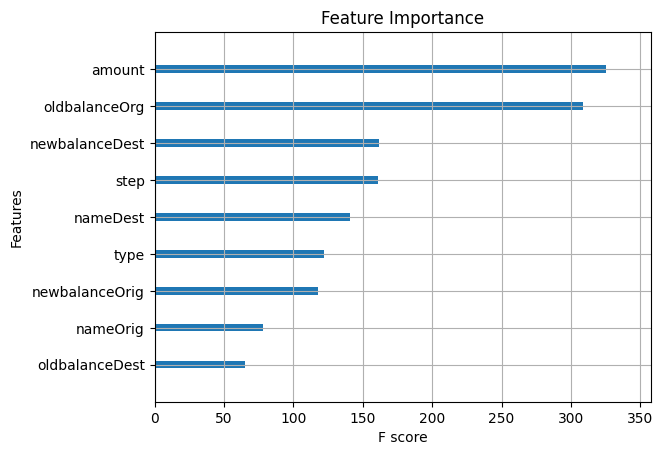

In [23]:
# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='weight', title="Feature Importance", show_values=False)
plt.show()

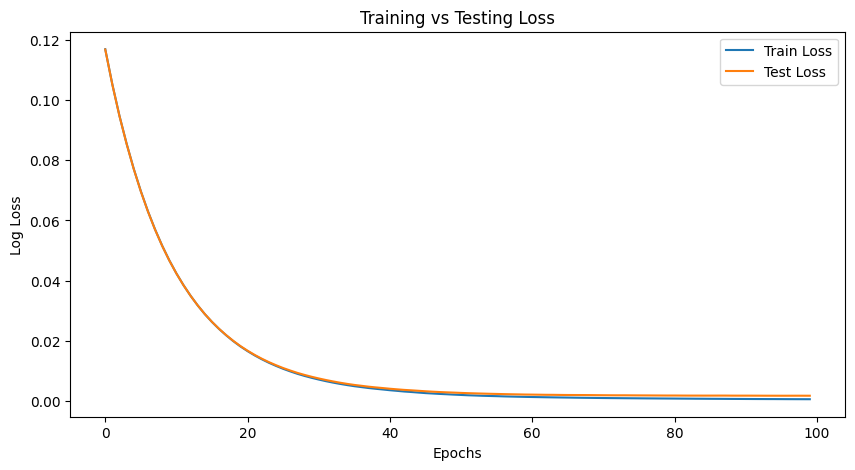

In [24]:
# Extract evaluation results
results = model.evals_result()

# Plot training and testing loss
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 5))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train Loss')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training vs Testing Loss')
plt.show()

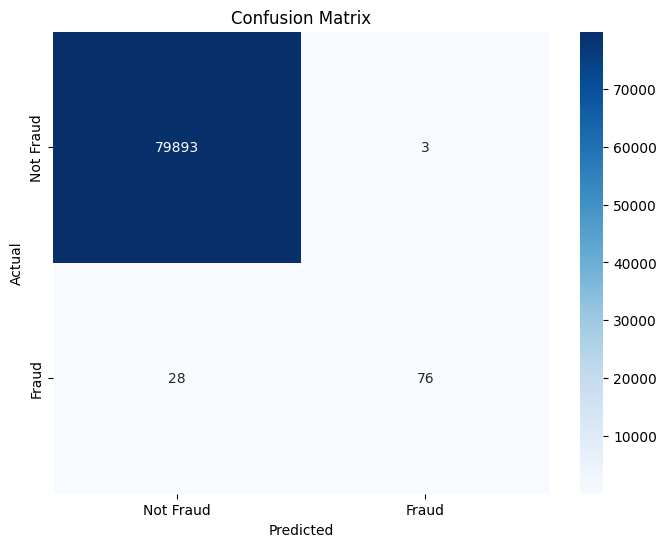

In [25]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

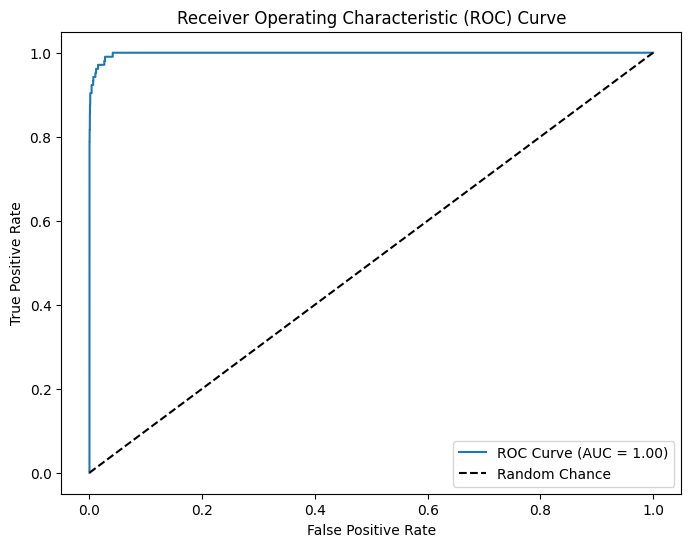

In [27]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [23]:
# Load the model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model('xgboost_fraud_model_with_names.h5')
print("Model loaded successfully!")

Model loaded successfully!
